COMP 646 FINAL PROJECT(Group 4): Integrating Semantic Segmentation, Style Transfer, and Caption Generation for Enhanced Visual Perception

Group Member: Yin Chen, Fangming Cheng, Owen Zhou
yc153@rice.edu, fc31@rice.edu, zz102@rice.edu

In [ ]:
# Download data for the flickr30k dataset and multi30k dataset.
#!wget -nc http://www.cs.virginia.edu/~vicente/vislang/flickr30k-images-small.tar.gz
!wget -nc http://www.cs.rice.edu/~vo9/vislang/flickr30k-images-small.tar.gz
!tar xf flickr30k-images-small.tar.gz
!git clone --recursive https://github.com/multi30k/dataset.git multi30k-dataset
!gunzip multi30k-dataset/data/task2/raw/*.gz
!gunzip multi30k-dataset/data/task2/tok/*.gz
!mkdir cache
# Concatenate five captions for each image
!paste -d "\n" multi30k-dataset/data/task2/raw/train.*.de > multi30k-dataset/data/task2/raw/train.all.de
!paste -d "\n" multi30k-dataset/data/task2/raw/val.*.de > multi30k-dataset/data/task2/raw/val.all.de
!paste -d "\n" multi30k-dataset/data/task2/raw/test_2016.*.de > multi30k-dataset/data/task2/raw/test_2016.all.de
# Use tokens instead of raw data
!paste -d "\n" multi30k-dataset/data/task2/tok/train.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/train.all.de
!paste -d "\n" multi30k-dataset/data/task2/tok/val.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/val.all.de
!paste -d "\n" multi30k-dataset/data/task2/tok/test_2016.lc.norm.tok.*.de > multi30k-dataset/data/task2/tok/test_2016.all.de


--2023-04-27 18:43:01--  http://www.cs.rice.edu/~vo9/vislang/flickr30k-images-small.tar.gz
Resolving www.cs.rice.edu (www.cs.rice.edu)... 128.42.207.26
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:80... connected.
HTTP request sent, awaiting response... 302 Found : Moved Temporarily
Location: https://www.cs.rice.edu/~vo9/vislang/flickr30k-images-small.tar.gz [following]
--2023-04-27 18:43:02--  https://www.cs.rice.edu/~vo9/vislang/flickr30k-images-small.tar.gz
Connecting to www.cs.rice.edu (www.cs.rice.edu)|128.42.207.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585965958 (559M) [application/x-gzip]
Saving to: ‘flickr30k-images-small.tar.gz’

flickr30k-images-sm 100%[===================>] 558.82M   605KB/s    in 15m 56s 

2023-04-27 18:58:59 (599 KB/s) - ‘flickr30k-images-small.tar.gz’ saved [585965958/585965958]

Cloning into 'multi30k-dataset'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (32/32), done.
rem

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def change_size(style_img, content_img):
    sty_x = style_img.size[0]
    sty_y = style_img.size[1]

    cont_x = content_img.size[0]
    cont_y = content_img.size[1]

    if sty_x > cont_x:

        sty_x = cont_x
        style_img = style_img.resize((sty_x, sty_y))
        if sty_y > cont_y:
            sty_y = cont_y
            style_img = style_img.resize((sty_x, sty_y))
        else:
            cont_y = sty_y
            content_img = content_img.resize((cont_x, cont_y))

    elif sty_x < cont_x:
        cont_x = sty_x
        content_img = content_img.resize((cont_x, cont_y)) 

        if sty_y > cont_y:
            sty_y = cont_y
            style_img = style_img.resize((sty_x, sty_y))
        else:
            cont_y = sty_y
            content_img = content_img.resize((cont_x, cont_y))

    return style_img, content_img


imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),  
    transforms.ToTensor()]) 

def input_image(style_img_path,content_img_path):
    style_img = Image.open(style_img_path)
    content_img = Image.open(content_img_path)
    return style_img,content_img

def image_loader(image):
    
    image = loader(image).unsqueeze(0)
   
    return image.to(device, torch.float)

In [ ]:

style_img, content_img = input_image("/content/style3.jpg","/content/flickr30k-images-small/1035019794.jpg")

style = image_loader(style_img)
content = image_loader(content_img)

style_img, content_img = change_size(style_img, content_img)

style_tensor = image_loader(style_img)
content_tensor = image_loader(content_img)

# style2 picture
style2_webp_path = "/content/styleM.webp"
style2_webp = Image.open(style2_webp_path)
style2 = image_loader(style2_webp)
style2_webp = style2_webp.resize((style_img.size[0], style_img.size[1]))

style2_tensor = image_loader(style2_webp)


# style3 picture
style3_webp_path = "/content/styleM2.webp"
style3_webp = Image.open(style3_webp_path)
style3 = image_loader(style3_webp)
style3_webp = style3_webp.resize((style_img.size[0], style_img.size[1]))

style3_tensor = image_loader(style3_webp)


unloader = transforms.ToPILImage()  

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)      
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 




# Semantic Segmentation ⬇


model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

model.eval()

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

input_img = unloader(content_tensor.squeeze(0))

input_img = input_img.convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(input_img)


input_batch = input_tensor.unsqueeze(0) 


if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]

output_predictions = output.argmax(0)



palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")


r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(input_img.size)
r.putpalette(colors)





class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


def gram_matrix(input):
    a, b, c, d = input.size()  
    
    features = input.view(a * b, c * d)  

    G = torch.mm(features, features.t())  

    return G.div(a * b * c * d)



class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


cnn = models.vgg19(pretrained=True).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

# content_layers_default = ['conv_4']
content_layers_default = ['conv_4', 'conv_5', 'conv_6', 'conv_7']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    
    content_losses = []
    style_losses = []

    
    model = nn.Sequential(normalization)

    i = 0  
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses



def get_input_optimizer(input_img):
    
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer



def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=400,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)


    input_img.data.clamp_(0, 1)

    return input_img





Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


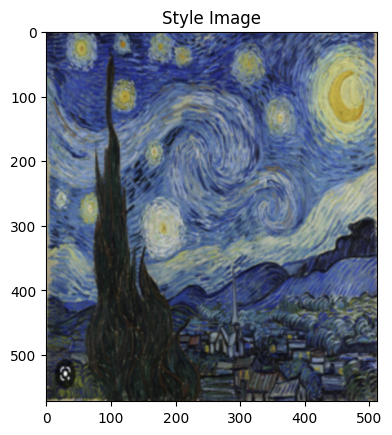

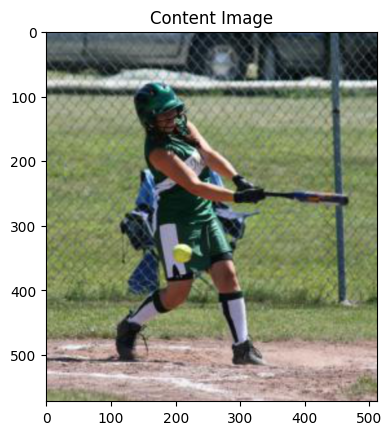

<Figure size 640x480 with 0 Axes>

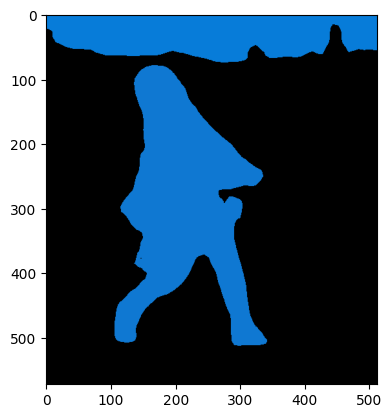

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
imshow(style_tensor, title='Style Image')

plt.figure()
imshow(content_tensor, title='Content Image')

plt.imshow(r)

input_img = content_tensor.clone()

plt.figure()
# imshow(input_img, title='Input Image')
# imshow(styled_output, title='Styled Output')


Building the style transfer model..
Optimizing..


<ipython-input-37-1b9e2f467f30>:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-37-1b9e2f467f30>:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 64.542191 Content Loss: 43.904427

run [100]:
Style Loss : 21.687901 Content Loss: 34.686634

run [150]:
Style Loss : 13.993591 Content Loss: 31.235613

run [200]:
Style Loss : 10.858004 Content Loss: 29.279579

run [250]:
Style Loss : 8.370087 Content Loss: 28.316128

run [300]:
Style Loss : 6.417105 Content Loss: 27.820843

run [350]:
Style Loss : 5.195903 Content Loss: 27.398062

run [400]:
Style Loss : 4.579228 Content Loss: 27.069914



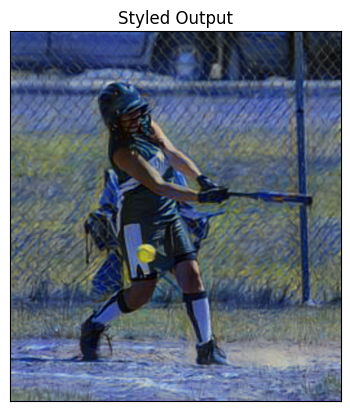

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 97.212608 Content Loss: 35.559532

run [100]:
Style Loss : 18.851179 Content Loss: 30.125750

run [150]:
Style Loss : 9.425205 Content Loss: 24.371038

run [200]:
Style Loss : 6.304947 Content Loss: 22.633717

run [250]:
Style Loss : 4.738730 Content Loss: 21.773973

run [300]:
Style Loss : 3.815381 Content Loss: 21.261917

run [350]:
Style Loss : 3.353914 Content Loss: 20.896889

run [400]:
Style Loss : 3.075783 Content Loss: 20.647299



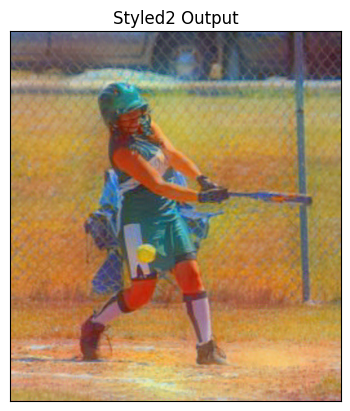

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 150.447220 Content Loss: 59.959896

run [100]:
Style Loss : 32.747318 Content Loss: 48.430336

run [150]:
Style Loss : 17.070160 Content Loss: 39.671516

run [200]:
Style Loss : 11.864085 Content Loss: 36.554832

run [250]:
Style Loss : 8.078281 Content Loss: 34.874077

run [300]:
Style Loss : 5.957861 Content Loss: 33.725506

run [350]:
Style Loss : 4.931778 Content Loss: 32.870342

run [400]:
Style Loss : 4.361745 Content Loss: 32.284828



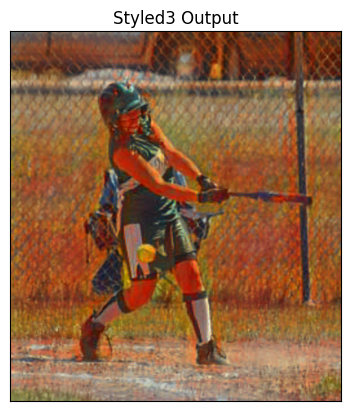

In [ ]:
# Start style transfer for each style picture

# style 1
input_imgT = copy.deepcopy(input_img)
content_tensorT = copy.deepcopy(content_tensor)

styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_tensorT, style_tensor, input_imgT)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled_output, title='Styled Output')

plt.show()

# style 2
input_imgT2 = copy.deepcopy(input_img)
content_tensorT2 = copy.deepcopy(content_tensor)

styled2_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_tensorT2, style2_tensor, input_imgT2)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled2_output, title='Styled2 Output')

plt.show()


# style 3
input_imgT3 = copy.deepcopy(input_img)
content_tensorT3 = copy.deepcopy(content_tensor)

styled3_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_tensorT3, style3_tensor, input_imgT3)

plt.figure()
plt.xticks([])
plt.yticks([])
imshow(styled3_output, title='Styled3 Output')

plt.show()

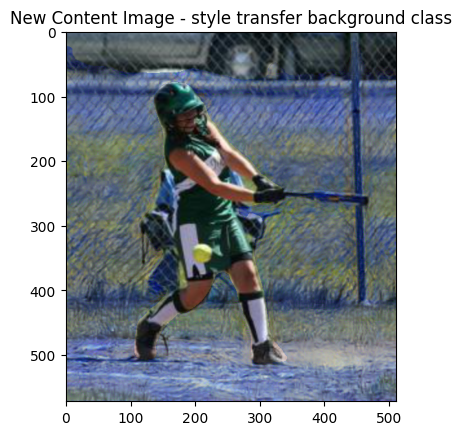

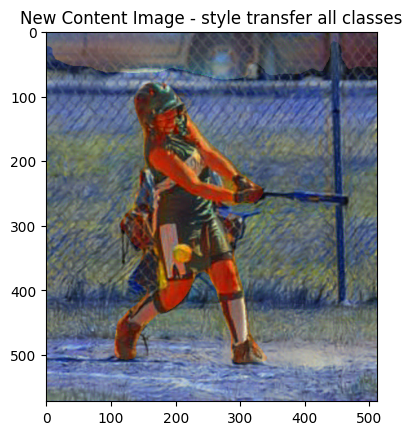

In [ ]:
# Combine style transfer and semantic segmentation

def segmentStyle(originTen, styledTens, segmenTen):
  differentValues = []
  differentValuesIndex = []

  for i in range(0, len(segmenTen)):
    for j in range(0, len(segmenTen[i])):
      if segmenTen[i][j].item() not in differentValues:
        differentValues.append(segmenTen[i][j].item())
        differentValuesIndex.append([])
        index = differentValues.index(segmenTen[i][j].item())
        differentValuesIndex[index].append([i,j])
      else:
        index = differentValues.index(segmenTen[i][j].item())
        differentValuesIndex[index].append([i,j])
      

# --------------------------------------------------------------------


  backgroundIndex = 0
  for i in range(0, len(differentValues)):
    if differentValues[i] == 0:
      backgroundIndex = differentValuesIndex[i]

  # add background style
  for i in range(0, len(backgroundIndex)):
    originTen[0, :, backgroundIndex[i][0], backgroundIndex[i][1]] = styledTens[0][0, :, backgroundIndex[i][0], backgroundIndex[i][1]]
  plt.figure()
  imshow(originTen, title='New Content Image - style transfer background class')


  styledTens = styledTens[1:]
  count = 0
  for i in range(0, len(differentValues)):
    if differentValues[i] != 0:
      currentIndex = differentValuesIndex[i]
      for j in range(0, len(currentIndex)):
        originTen[0, :, currentIndex[j][0], currentIndex[j][1]] = styledTens[count][0, :, currentIndex[j][0], currentIndex[j][1]]
      count = count + 1

  plt.figure()
  imshow(originTen, title='New Content Image - style transfer all classes')

  return


# originTen = copy.deepcopy(content_tensor)

styledTen = styled_output

styled2Ten = styled2_output

styled3Ten = styled3_output

segmenTen = output_predictions

styledTenss = [styledTen, styled2Ten, styled3Ten]
# # styledTens = copy.deepcopy(styledTenss)

segmentStyle(content_tensor, styledTenss, segmenTen)

In [ ]:
improved_style_img, improved_content_img = input_image("/content/dnson.jpg","/content/garden.jpg")

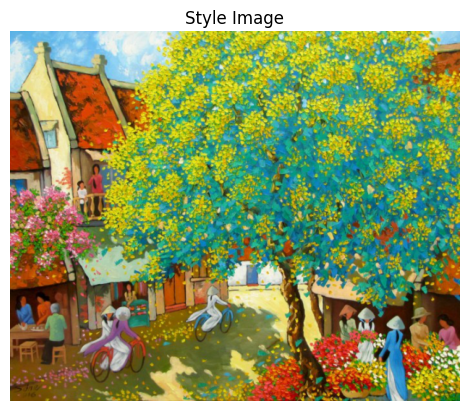

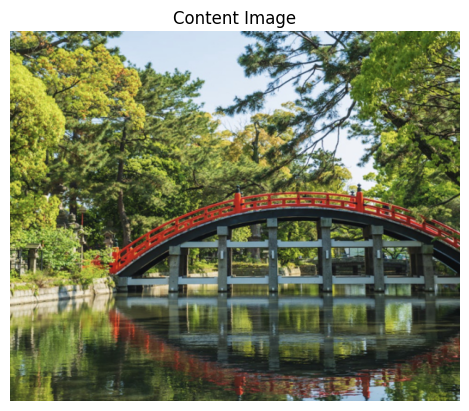

Building the style transfer model..
Optimizing..


<ipython-input-6-378ebf75afe5>:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-6-378ebf75afe5>:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 520.431458 Content Loss: 58.247902

run [100]:
Style Loss : 142.297058 Content Loss: 56.552563

run [150]:
Style Loss : 44.663094 Content Loss: 53.049114

run [200]:
Style Loss : 19.128191 Content Loss: 48.135056

run [250]:
Style Loss : 11.621331 Content Loss: 41.982330

run [300]:
Style Loss : 8.104177 Content Loss: 36.669212

run [350]:
Style Loss : 6.059581 Content Loss: 31.879864

run [400]:
Style Loss : 4.835567 Content Loss: 28.082024



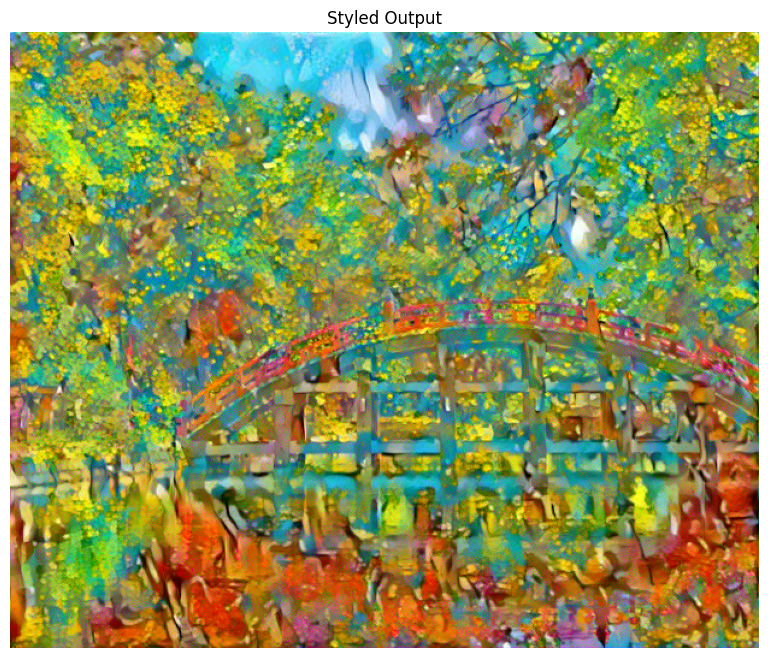

In [ ]:
style = image_loader(improved_style_img)
content = image_loader(improved_content_img)

style_img, content_img = change_size(improved_style_img, improved_content_img)

style_tensor = image_loader(style_img)
content_tensor = image_loader(content_img)

input_img = content_tensor.clone()
# style_tensor_copy = style_tensor.clone()
# content_tensor_copy = content_tensor.clone()

plt.figure()
plt.axis('off')
imshow(style_tensor, title='Style Image')

plt.figure()
plt.axis('off')
imshow(content_tensor, title='Content Image')

styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_tensor, style_tensor, input_img)

plt.figure(figsize = (12,8))
plt.axis('off')
imshow(styled_output, title='Styled Output')

In [ ]:
content_layers_default = ['conv_4', 'conv_5', 'conv_6', 'conv_7']

Building the style transfer model..
Optimizing..


<ipython-input-9-1b9e2f467f30>:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-9-1b9e2f467f30>:136: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


run [50]:
Style Loss : 476.078430 Content Loss: 361.483002

run [100]:
Style Loss : 154.294800 Content Loss: 277.238739

run [150]:
Style Loss : 57.936214 Content Loss: 220.737457

run [200]:
Style Loss : 30.055721 Content Loss: 186.286804

run [250]:
Style Loss : 20.718328 Content Loss: 161.791718

run [300]:
Style Loss : 17.074345 Content Loss: 144.134109

run [350]:
Style Loss : 14.058106 Content Loss: 132.612015

run [400]:
Style Loss : 12.174331 Content Loss: 123.880386



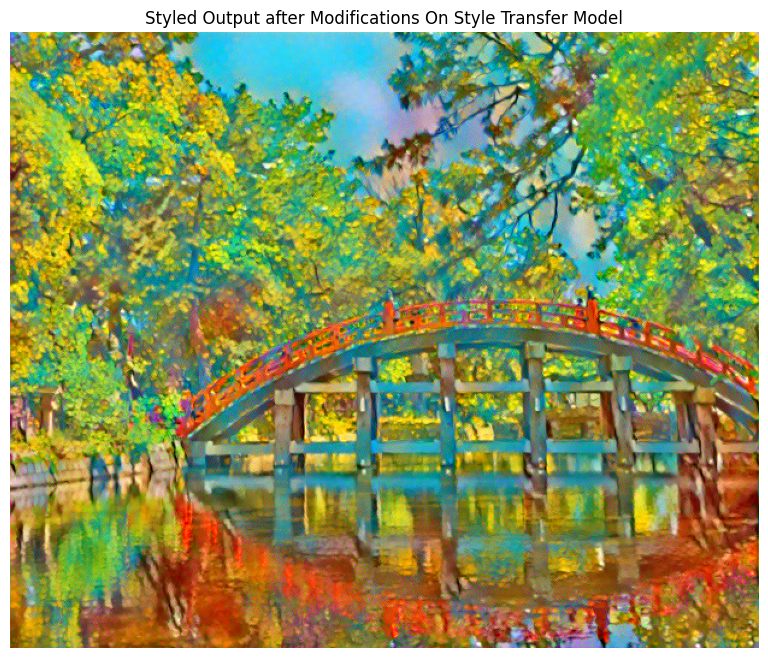

In [ ]:
style = image_loader(improved_style_img)
content = image_loader(improved_content_img)

style_img, content_img = change_size(improved_style_img, improved_content_img)

style_tensor = image_loader(style_img)
content_tensor = image_loader(content_img)

input_img = content_tensor.clone()
styled_output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_tensor, style_tensor, input_img)
plt.figure(figsize = (12,8))
plt.axis('off')
imshow(styled_output, title='Styled Output after Modifications On Style Transfer Model')

In [ ]:
!pip install torchtext==0.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.9 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1


In [ ]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 25.1 MB/s eta 0:00:00


In [ ]:
import torch
import torchtext
import pandas, os, pickle
from tqdm import tqdm
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.nn.utils.rnn import pad_sequence
from filelock import FileLock

class Multi30kDataset(Dataset):
    def __init__(self, tokenizer, 
                 dataset_file_path: str, # location of the multi30k local cloned repo.
                 image_file_path: str, # location of the flickr30k images.
                 split: str, # train, val, test_2016
                 language: str, # en, de
                 vocabulary_size: int,
                 image_transform = None,
                 cache_path = None,
                 overwrite_cache = False):
        
        assert os.path.exists(dataset_file_path), dataset_file_path
        assert os.path.exists(image_file_path), image_file_path
        assert language in ['en', 'de'], 'invalid language'
        assert split in ['val', 'train', 'test_2016'], 'invalid split'
        assert cache_path, 'provide a writtable cache path'
        assert vocabulary_size > 0
        
        self.image_file_path = image_file_path
        self.language = language
        self.split = split
        self.image_transform = image_transform
        self.textTokenizer = tokenizer
        
        # Open split file.
        data_filenames = pandas.read_csv(
            os.path.join(dataset_file_path, 'data/task2/image_splits/', '%s_images.txt' % self.split),
            header = None)

        # Open raw text file.
        
        data_text = pandas.read_csv(
            os.path.join(dataset_file_path, 'data/task2/tok/', '%s.all.%s' % (self.split, self.language)),
            header = None, sep = '\t\n')
         
        # Tokenize and add examples to the local variables.
        self.images = [image_filename for image_filename in data_filenames[0]]
            
        # Cache directory file.
        cached_features_file = os.path.join(
            cache_path, "cached_toks_{}_{}_{}".format(tokenizer.__class__.__name__, self.split, self.language))
        
        # In case of multi-threaded execution and to avoid recomputing this all the time.
        lock_path = cached_features_file + ".lock"
        with FileLock(lock_path):
            if os.path.exists(cached_features_file) and not overwrite_cache:
                with open(cached_features_file, "rb") as handle:
                    self.texts = torch.load(handle)
            else:
                # Tokenize and add examples to the local variables.
                self.texts = list()
                self.images = list()
                for (ii, caption) in tqdm(enumerate(data_text[0])):
                    # if ii > 999:break
                    tokenized_caption = tokenizer.preprocess(caption)
                    self.texts.append(tokenized_caption)
                    # Every image has five captions
                    self.images.append(data_filenames[0][ii//5])
            
                # If needed build the tokenizer vocabulary.
                if self.split == "train" and not hasattr(tokenizer, "vocab"):
                    tokenizer.build_vocab(self.texts, max_size = vocabulary_size)

                # Numericalize all texts.
                for i in tqdm(range(0, len(self.texts))):
                    self.texts[i] = tokenizer.process([self.texts[i]])
                    
                # Save processed texts.
                with open(cached_features_file, "wb") as handle:
                    torch.save(self.texts, handle)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        image = Image.open(os.path.join(self.image_file_path, self.images[i])).convert("RGB")
        if self.image_transform:
            image = self.image_transform(image) 
        return image, self.texts[i].squeeze()
    
    # To be used in the Data Loader collate_fn parameter.
    def create_batch(self, batch):
        images, texts = zip(*batch)

        # Compute text lengths for Pytorch's RNN library.
        text_lengths = [len(text) for text in texts]

        # Stack images and pad text.
        stacked_images = torch.stack(images)
        padded_texts = pad_sequence(texts, batch_first = self.textTokenizer.batch_first, 
                                    padding_value = self.textTokenizer.vocab.stoi["<pad>"])

        return stacked_images, padded_texts, text_lengths
    

In [ ]:
import os
import argparse
import torch
import torchtext
import torchtext.data
import torchvision.transforms as transforms

parser = argparse.ArgumentParser()
parser.add_argument('--language', type =  str,
                    default = 'de', help = 'Language to load')
parser.add_argument('--max_vocabulary_size', type =  int,
                    default = 12000, help = 'Vocabulary size to use')
parser.add_argument('--dataset_path', type =  str, default = 'multi30k-dataset',
                    help = 'path to the Multi30k dataset')
parser.add_argument('--images_path', type =  str, default = 'flickr30k-images-small',
                    help = 'path to the Multi30k dataset')
parser.add_argument('--cache_path', type =  str, default = 'cache',
                    help = 'path to cached data files')

config, _ = parser.parse_known_args()

# Create the tokenizer for this language and model.
textTokenizer = torchtext.data.Field(sequential = True,
                                            init_token = "<start>", eos_token = "<end>", 
                                            pad_token = "<pad>", unk_token = "<unk>",
                                            batch_first = True)
    
# Create image transforms using standard Imagenet-based model transforms.
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      normalize])

test_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      normalize])

# Create dataset classes for training and validation.
trainset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                                   'train', config.language, config.max_vocabulary_size,
                                   image_transform =  train_transform,
                                   cache_path = config.cache_path, overwrite_cache = True)
valset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                                 'val', config.language, config.max_vocabulary_size,
                                 image_transform = test_transform,
                                 cache_path = config.cache_path, overwrite_cache = True)

<ipython-input-12-2c22ab785454>:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text = pandas.read_csv(
145000it [00:01, 112182.68it/s]
100%|██████████| 145000/145000 [00:02<00:00, 58468.50it/s]
<ipython-input-12-2c22ab785454>:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text = pandas.read_csv(
5070it [00:00, 148097.15it/s]
100%|██████████| 5070/5070 [00:00<00:00, 92373.51it/s]


In [ ]:
import torch.nn as nn
import torchvision.models as models

class ImageEncoder(nn.Module):
    # Encode images using Resnet-152
    def __init__(self, encoding_size: int):
        super(ImageEncoder, self).__init__()
        self.base_network = models.resnet152(pretrained = True)
        self.base_network.fc = nn.Linear(self.base_network.fc.in_features, encoding_size)
        self.bn = nn.BatchNorm1d(encoding_size, momentum=0.01)
        self.init_weights()

    def init_weights(self):
        
        self.base_network.fc.weight.data.normal_(0.0, 0.02)
        self.base_network.fc.bias.data.fill_(0)

    def forward(self, image):

        with torch.no_grad():

            x = self.base_network.conv1(image)
            x = self.base_network.bn1(x)
            x = self.base_network.relu(x)
            x = self.base_network.maxpool(x)
          
            x = self.base_network.layer1(x)
            x = self.base_network.layer2(x)
            x = self.base_network.layer3(x)
            x = self.base_network.layer4(x)
          
            x = self.base_network.avgpool(x)
            x = torch.flatten(x, 1)
  
        featureMap = self.base_network.fc(x)
        featureMap = self.bn(featureMap)
        return featureMap


In [ ]:
# Now to data loaders and batch building.
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = 128, 
                                           num_workers = 2,
                                           shuffle = True,
                                           collate_fn = trainset.create_batch)
val_loader = torch.utils.data.DataLoader(valset, 
                                         batch_size = 128, 
                                         num_workers = 2,
                                         shuffle = False,
                                         collate_fn = valset.create_batch)
(images, texts, text_lengths) = next(iter(val_loader))

# print(images.shape, texts.shape, text_lengths)

In [ ]:
image_encoder = ImageEncoder(512)
image_encoder.eval()
encoded_images = image_encoder(images)
# print(encoded_images.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch.nn as nn
from torch.nn import functional as F


class TextDecoder(nn.Module):
    def __init__(self, input_size: int, state_size: int, vocab_size: int):
        super(TextDecoder, self).__init__()
        self.state_size = state_size
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnnCell = nn.LSTMCell(input_size, state_size, bias=True)
        self.predictionLayer = nn.Linear(state_size, vocab_size)
        self.init_weights()
        
    def dummy_input_state(self, batch_size):

        return (torch.zeros(batch_size, self.state_size), torch.zeros(batch_size, self.state_size))
    
    def init_weights(self):
        
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.predictionLayer.bias.data.fill_(0)
        self.predictionLayer.weight.data.uniform_(-0.1, 0.1)
        
    def forward(self, input_state, current_token_id):
        # Embed the input token id into a vector.
        embedded_token = self.embedding(current_token_id)

        # Pass the embedding through the RNN cell.
        h,c = self.rnnCell(embedded_token, input_state)
        
        # Output prediction.
        prediction = self.predictionLayer(F.relu(h))
        
        return prediction, (h,c)



In [ ]:
# Example usage.
text_decoder = TextDecoder(300, 512, len(textTokenizer.vocab))

# Pick the first token of the text batch (after the <start> token).
sample_input_token = texts[:, 1]
batch_size = texts.shape[0]
initial_state = text_decoder.dummy_input_state(batch_size)

# Compute prediction in current time step and state vector for next time step.
prediction, output_state = text_decoder(initial_state, sample_input_token)


In [ ]:
import random 
import pytorch_lightning as pl

# Image Captioning module.
# Using pytorch-lightning for simplicity.

class ImageCaptioner(pl.LightningModule):
    def __init__(self, textTokenizer, val_data = None, embedding_size = 512, state_size = 1024):
        super(ImageCaptioner, self).__init__()
        self.vocabulary_size = len(textTokenizer.vocab)
        self.padding_token_id = textTokenizer.vocab.stoi["<pad>"]

        
        self.val_data = val_data
        
        
        # Create image encoder and text decoder.
        self.image_encoder = ImageEncoder(state_size)
        self.text_decoder = TextDecoder(embedding_size, 
                                        state_size, 
                                        self.vocabulary_size)
        
        self.criterion = nn.CrossEntropyLoss(
            ignore_index = self.padding_token_id)
        
        self.init_image_transforms()
        self.text_tokenizer = textTokenizer

        self.image_encoder_learning_rate = 1e-4
        self.text_decoder_learning_rate = 1e-3
    
    def init_image_transforms(self):
        # Create image transforms using standard Imagenet-based model transforms.
        normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                         std = [0.229, 0.224, 0.225])
        
        self.image_train_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.RandomCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                normalize])
        
        self.image_test_transform = \
            transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                normalize])

    # Predict text given image -- input text is for "teacher forcing" only.
    def forward(self, image, text, lengths, teacher_forcing = 1.0):
        # Keep output scores for tokens in a list.
        predicted_scores = list()
        
        # Encode the image.
        encoded_image = self.image_encoder(image)
        
        # Grab the first token in the sequence.
        start_token = text[:, 0]  # This should be the <start> symbol.
        
        # Predict the first token from the start token embedding 
        # and feed the image as the initial state.
        # let first input state = None
        token_scores, state = self.text_decoder((encoded_image,encoded_image), start_token)
        predicted_scores.append(token_scores)
        
        # Iterate as much as the longest sequence in the batch.
        # minus 1 because we already fed the first token above.
        # minus 1 because we don't need to feed the end token <end>.
        for i in range(0, max(lengths) - 2):
            if random.random() < teacher_forcing:
                current_token = text[:, i + 1]
            else:
                _, max_token = token_scores.max(dim = 1)
                current_token = max_token.detach() # No backprop.
            token_scores, state = self.text_decoder(state, current_token)
            predicted_scores.append(token_scores)
            
        # torch.stack(,1) forces batch_first = True on this output.
        return torch.stack(predicted_scores, 1), lengths

    def training_step(self, batch, batch_idx, optimizer_idx):
        images, texts, lengths = batch

        # Compute the predicted texts.
        predicted_texts, _ = self(images, texts, lengths, 
                                  teacher_forcing = 1.0)
        
        # Define the target texts. 
        # We have to predict everything except the <start> token.
        target_texts =  texts[:, 1:].contiguous()

        # Use cross entropy loss.
        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('train_loss', loss, on_epoch = True)
        return {'loss': loss}

    def validation_step(self, batch, batch_idx):
        images, texts, lengths = batch

        predicted_texts, _ = self(images, texts, lengths,
                                  teacher_forcing = 0.0)
        
        target_texts = texts[:, 1:].contiguous()

        loss = self.criterion(predicted_texts.view(-1, self.vocabulary_size),
                              target_texts.view(-1))
        self.log('val_loss', loss, on_epoch = True)
        return {'val_loss': loss}

    def validation_epoch_end(self, outputs):
        loss_mean = torch.stack([x['val_loss'] for x in outputs]).mean()
        print('Validation loss %.2f' %  loss_mean)
        
        return {'val_loss': loss_mean}
    
    def training_epoch_end(self, outputs):
        
        loss_mean = torch.stack([x['loss'] for x in outputs[0]]).mean()
        print('Training loss %.2f' %  loss_mean)


    def configure_optimizers(self):
        return [torch.optim.SGD(list(self.image_encoder.base_network.fc.parameters())+\
                                list(self.image_encoder.bn.parameters()),
                                lr = self.image_encoder_learning_rate), \
                torch.optim.Adam(self.text_decoder.parameters(), 
                                 lr = self.text_decoder_learning_rate)], []


In [ ]:
# Download the checkpoint
# !wget -nc https://www.cs.virginia.edu/~zy3cx/image_captioner_weights.ckpt
!wget -nc https://www.cs.rice.edu/~vo9/vislang/image_captioner_weights.ckpt

# # Create image captioner.
image_captioner = ImageCaptioner(textTokenizer)

# Load the pre-trained model
checkpoint = torch.load('image_captioner_weights.ckpt')
image_captioner.load_state_dict(checkpoint['state_dict'])

File ‘image_captioner_weights.ckpt’ already there; not retrieving.



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
# Write a function to generate captions

def generate_caption(model, image, max_length = 100):
  
  model.eval()
  image = model.image_test_transform(image).unsqueeze(0)
  encoded_images = model.image_encoder(image)
  # print(encoded_images.shape)
  input_token = torch.tensor(model.text_tokenizer.vocab.stoi["<start>"]).unsqueeze(0)
  input_state = (encoded_images,encoded_images)
  predicted_caption = []
  
  
  for i in range(max_length):
    token_scores, input_state = image_captioner.text_decoder(input_state, input_token)
    _, max_token_idx = token_scores.max(dim=1)
    max_token_idx = max_token_idx.item()

    if max_token_idx == image_captioner.text_tokenizer.vocab.stoi["<end>"]:
        break

    predicted_caption.append(image_captioner.text_tokenizer.vocab.itos[max_token_idx])
    input_token = torch.tensor(max_token_idx).unsqueeze(0)

  caption = " ".join(predicted_caption)
  
  return caption



In [ ]:
!unzip cs646project-images.zip

Archive:  cs646project-images.zip
   creating: 10010052/
  inflating: 10010052/style4.png     
   creating: __MACOSX/
   creating: __MACOSX/10010052/
  inflating: __MACOSX/10010052/._style4.png  
  inflating: 10010052/style1.png     
  inflating: __MACOSX/10010052/._style1.png  
  inflating: 10010052/content.png    
  inflating: __MACOSX/10010052/._content.png  
  inflating: 10010052/styled2.png    
  inflating: __MACOSX/10010052/._styled2.png  
  inflating: 10010052/style2.png     
  inflating: __MACOSX/10010052/._style2.png  
  inflating: 10010052/style3.png     
  inflating: __MACOSX/10010052/._style3.png  
  inflating: 10010052/styled1.png    
  inflating: __MACOSX/10010052/._styled1.png  
  inflating: 10010052/seg.png        
  inflating: __MACOSX/10010052/._seg.png  
   creating: 1005216151/
  inflating: 1005216151/style1.png   
   creating: __MACOSX/1005216151/
  inflating: __MACOSX/1005216151/._style1.png  
  inflating: 1005216151/content.png  
  inflating: __MACOSX/1005216151/

<ipython-input-12-2c22ab785454>:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text = pandas.read_csv(
5070it [00:00, 94265.30it/s]
100%|██████████| 5070/5070 [00:00<00:00, 57472.83it/s]
<ipython-input-12-2c22ab785454>:41: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data_text = pandas.read_csv(
145000it [00:01, 91218.77it/s]
100%|██████████| 145000/145000 [00:02<00:00, 53244.70it/s]


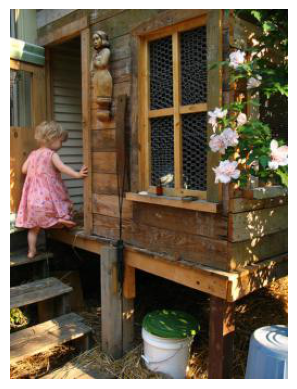

Predicted: ein kleines mädchen in einem rotkarierten kleid steht vor einer glastür und schaut auf ein handy .
True: <start> ein mädchen im rosa kleid klettert in eine stall <end>


In [ ]:
import matplotlib.pyplot as plt

# Create dataset classes for training and validation.
testset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                           'val', config.language, config.max_vocabulary_size,
                           cache_path = config.cache_path, overwrite_cache = True)

trainset = Multi30kDataset(textTokenizer, config.dataset_path, config.images_path, 
                           'train', config.language, config.max_vocabulary_size,
                           cache_path = config.cache_path, overwrite_cache = True)

# No need to use GPU for this part, make sure it is turned off.
image_captioner =  image_captioner.cpu()

image, text = trainset[10]
caption = generate_caption(image_captioner, image)

plt.figure(); plt.imshow(image); plt.axis('off');plt.show()
print("Predicted: {}".format(caption))
print("True: {}".format(" ".join([image_captioner.text_tokenizer.vocab.itos[c]
                             for c in text.tolist()])))

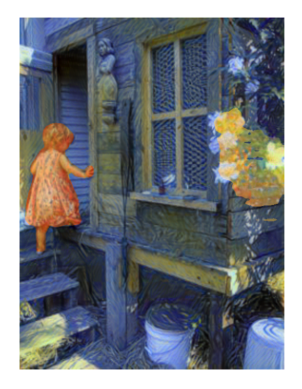

Predicted: ein mann in einem <unk> .


In [ ]:
girl_after_style_transfer = Image.open('/content/1000268201/styled2.png').convert("RGB")

caption = generate_caption(image_captioner, girl_after_style_transfer)

plt.figure(); plt.imshow(girl_after_style_transfer); plt.axis('off');plt.show()
print("Predicted: {}".format(caption))

In [ ]:
def loadPicture(contentPath, stylePaths):

  stylePath1 = stylePaths[0]

  # style1 picture and content picture
  style_img, content_img = input_image(stylePath1,contentPath)


  style = image_loader(style_img)
  content = image_loader(content_img)

  style_img, content_img = change_size(style_img, content_img)

  style_tensor = image_loader(style_img)
  content_tensor = image_loader(content_img)

  result = [content_tensor, style_tensor]

  for i in range(1, len(stylePaths)):
    style_path = stylePaths[i]
    style_picture = Image.open(style_path)
    styleImg = image_loader(style_picture)
    style_picture = style_picture.resize((style_img.size[0], style_img.size[1]))
    style_tensor1 = image_loader(style_picture)

    result.append(style_tensor1)

  return result

In [ ]:
stylePath1 = "/content/style3.jpg"
stylepath2 = "/content/styleM.webp"
stylepath3 = "/content/styleM2.webp"
stylepath4 = "/content/styleM3.jpeg"
stylepath5 = "/content/styleM4.jpeg"
stylePaths = [stylePath1, stylepath2, stylepath3, stylepath4, stylepath5]

In [ ]:
image_list = [
'1000092795',
'10002456',
'1000268201',
'1000344755',
'1000366164',
'1000523639',
'1000919630',
'10010052',
'1001465944',
'1001545525',
'1001573224',
'1001633352',
'1001773457',
'1001896054',
'100197432',
'100207720',
'1002674143',
'1003163366',
'1003420127',
'1003428081',
'100444898',
'1005216151',
'100577935',
'1006452823',
'100652400']

In [ ]:
true_caption_list = []
caption_before_style_transfer_list = []
caption_after_style_transfer_list = []

preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])


for i in range(len(image_list)):
  _, true_caption = trainset[i*5]
  # print(image_list[i])
  before_style_image_path = '/content/' + image_list[i] + '/content.png'
  after_style_image_path = '/content/' + image_list[i] + '/styled2.png'

  before_transfer_img = Image.open(before_style_image_path).convert('RGB')
  after_transfer_img = Image.open(after_style_image_path).convert('RGB')

  caption_before_style_transfer = generate_caption(image_captioner, before_transfer_img)
  caption_after_style_transfer = generate_caption(image_captioner, after_transfer_img)


  true_caption_text = " ".join([image_captioner.text_tokenizer.vocab.itos[c]
                             for c in true_caption.tolist()])
  true_caption_list.append(true_caption_text)
  caption_before_style_transfer_list.append(caption_before_style_transfer)
  caption_after_style_transfer_list.append(caption_after_style_transfer)


In [ ]:
print(true_caption_list)
print(caption_before_style_transfer_list)
print(caption_after_style_transfer_list)

['<start> zwei männer betrachten etwas im garten <end>', '<start> die männer arbeiten an der seilbahn . <end>', '<start> ein mädchen im rosa kleid klettert in eine stall <end>', '<start> ein mann auf einer leiter putzt ein fenster <end>', '<start> ein mann am herd füllt den teller eines zweiten mannes . <end>', '<start> ein <unk> bearbeitet das kostüm eines gitarristen . <end>', '<start> ein junger mann hält eine <unk> plüschfigur . <end>', '<start> eine frau im blauen shirt telefoniert beim <unk> . <end>', '<start> 2 <unk> und ein mann laufen auf dem bordstein <end>', '<start> zwei männer mit nackten oberkörper die über ein geländer springen . <end>', '<start> mädchen im <unk> . <end>', '<start> ein paar jugendliche springen eine treppe hinunter . <end>', '<start> zwei hunde kämpfen <end>', '<start> ein bauarbeiter der auf einem traktor fährt . <end>', '<start> einige menschen stehen neben einem bus . <end>', '<start> eine junge frau , die mit einem sieb einen kuchen mit <unk> bestreu

true + before style transfer

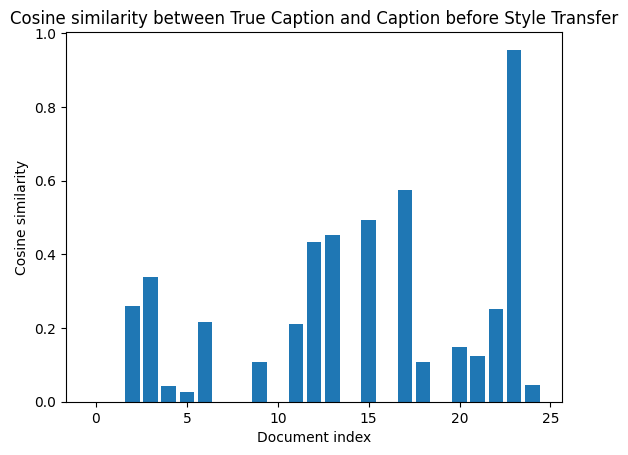

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# define the two lists of documents
# create a TF-IDF vectorizer and fit it to the two lists of documents
tfidf = TfidfVectorizer()
tfidf.fit(true_caption_list + caption_before_style_transfer_list)

# transform the documents into TF-IDF vectors
tfidf_list1 = tfidf.transform(true_caption_list)
tfidf_list2 = tfidf.transform(caption_before_style_transfer_list)

# calculate the cosine similarity between each pair of documents
similarity_scores = []
for i in range(len(true_caption_list)):
    similarity_scores.append(cosine_similarity(tfidf_list1[i], tfidf_list2[i])[0, 0])

# plot the similarity scores as a bar chart
fig, ax = plt.subplots()
ax.bar(range(len(true_caption_list)), similarity_scores)
ax.set_xlabel('Document index')
ax.set_ylabel('Cosine similarity')
ax.set_title('Cosine similarity between True Caption and Caption before Style Transfer')
plt.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight")
plt.show()



true + after style transfer

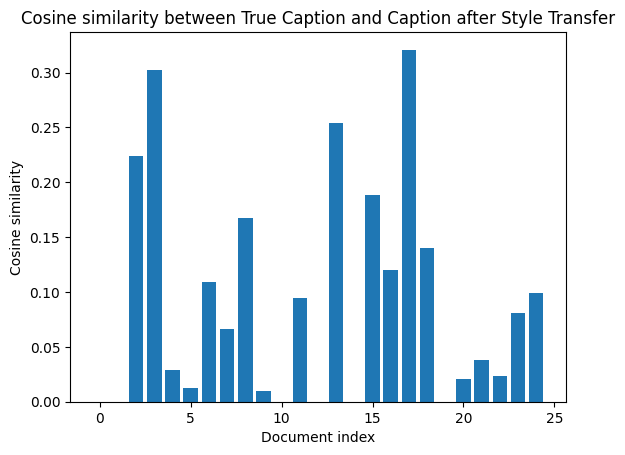

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# define the two lists of documents
# create a TF-IDF vectorizer and fit it to the two lists of documents
tfidf = TfidfVectorizer()
tfidf.fit(true_caption_list + caption_after_style_transfer_list)

# transform the documents into TF-IDF vectors
tfidf_list1 = tfidf.transform(true_caption_list)
tfidf_list2 = tfidf.transform(caption_after_style_transfer_list)

# calculate the cosine similarity between each pair of documents
similarity_scores = []
for i in range(len(true_caption_list)):
    similarity_scores.append(cosine_similarity(tfidf_list1[i], tfidf_list2[i])[0, 0])

# plot the similarity scores as a bar chart
fig, ax = plt.subplots()
ax.bar(range(len(true_caption_list)), similarity_scores)
ax.set_xlabel('Document index')
ax.set_ylabel('Cosine similarity')
ax.set_title('Cosine similarity between True Caption and Caption after Style Transfer')
plt.show()


before style transfer + after style transfer

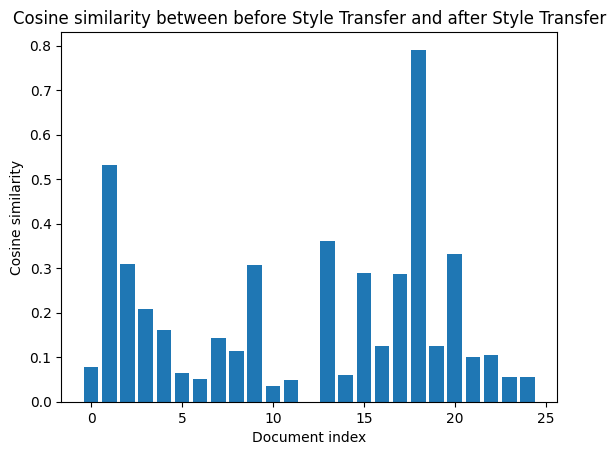

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# define the two lists of documents
# create a TF-IDF vectorizer and fit it to the two lists of documents
tfidf = TfidfVectorizer()
tfidf.fit(caption_before_style_transfer_list + caption_after_style_transfer_list)

# transform the documents into TF-IDF vectors
tfidf_list1 = tfidf.transform(caption_before_style_transfer_list)
tfidf_list2 = tfidf.transform(caption_after_style_transfer_list)

# calculate the cosine similarity between each pair of documents
similarity_scores = []
for i in range(len(caption_before_style_transfer_list)):
    similarity_scores.append(cosine_similarity(tfidf_list1[i], tfidf_list2[i])[0, 0])

# plot the similarity scores as a bar chart
fig, ax = plt.subplots()
ax.bar(range(len(caption_before_style_transfer_list)), similarity_scores)
ax.set_xlabel('Document index')
ax.set_ylabel('Cosine similarity')
ax.set_title('Cosine similarity between before Style Transfer and after Style Transfer')
plt.show()


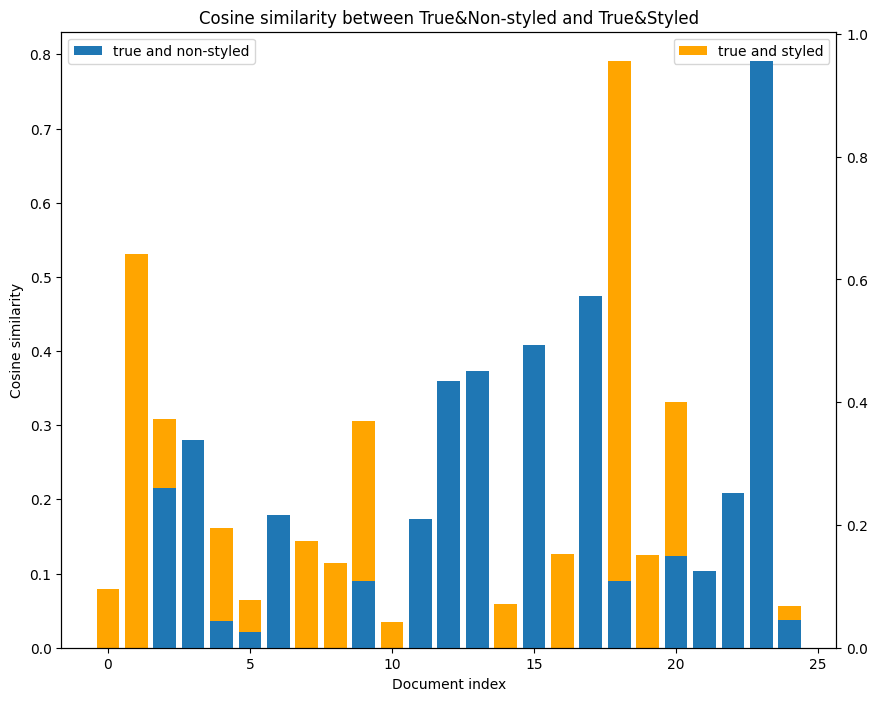

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# define the two lists of documents
# create a TF-IDF vectorizer and fit it to the two lists of documents
tfidf1 = TfidfVectorizer()
tfidf1.fit(true_caption_list + caption_before_style_transfer_list)

# transform the documents into TF-IDF vectors
tfidf_list1 = tfidf1.transform(true_caption_list)
tfidf_list2 = tfidf1.transform(caption_before_style_transfer_list)

tfidf2 = TfidfVectorizer()
tfidf2.fit(caption_before_style_transfer_list + caption_after_style_transfer_list)
tfidf_list3 = tfidf2.transform(caption_before_style_transfer_list)
tfidf_list4 = tfidf2.transform(caption_after_style_transfer_list)

# calculate the cosine similarity between each pair of documents
similarity_scores1 = []
similarity_scores2 = []
for i in range(len(true_caption_list)):
    similarity_scores1.append(cosine_similarity(tfidf_list1[i], tfidf_list2[i])[0, 0])
    similarity_scores2.append(cosine_similarity(tfidf_list3[i], tfidf_list4[i])[0, 0])

# plot the similarity scores as a bar chart
fig, ax = plt.subplots()
ax.bar(range(len(true_caption_list)), similarity_scores2, color = "orange", label = "true and styled")
ax2 = ax.twinx()
ax2.bar(range(len(true_caption_list)), similarity_scores1, label = "true and non-styled")
ax.set_xlabel('Document index')
ax.set_ylabel('Cosine similarity')
ax.set_title('Cosine similarity between True&Non-styled and True&Styled')
ax.legend()
ax2.legend()
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
fig.set_size_inches(10,8)
plt.show()


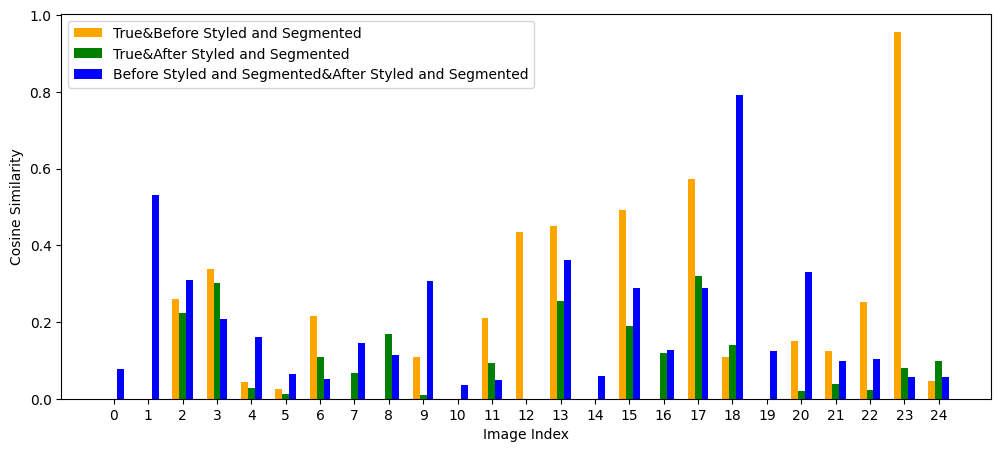

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np

width = 0.2
x = np.arange(25)

tfidf1 = TfidfVectorizer()
tfidf1.fit(true_caption_list + caption_before_style_transfer_list)
tfidf_list1 = tfidf1.transform(true_caption_list)
tfidf_list2 = tfidf1.transform(caption_before_style_transfer_list)

tfidf2 = TfidfVectorizer()
tfidf2.fit(true_caption_list + caption_after_style_transfer_list)
tfidf_list3 = tfidf2.transform(true_caption_list)
tfidf_list4 = tfidf2.transform(caption_after_style_transfer_list)

tfidf3 = TfidfVectorizer()
tfidf3.fit(caption_before_style_transfer_list + caption_after_style_transfer_list)
tfidf_list5 = tfidf3.transform(caption_before_style_transfer_list)
tfidf_list6 = tfidf3.transform(caption_after_style_transfer_list)

similarity_scores1 = []
similarity_scores2 = []
similarity_scores3 = []

for i in range(len(true_caption_list)):
    similarity_scores1.append(cosine_similarity(tfidf_list1[i], tfidf_list2[i])[0, 0])
    similarity_scores2.append(cosine_similarity(tfidf_list3[i], tfidf_list4[i])[0, 0])
    similarity_scores3.append(cosine_similarity(tfidf_list5[i], tfidf_list6[i])[0, 0])


fig, ax = plt.subplots()
bar1 = plt.bar(x, similarity_scores1, width, color = 'orange')
  

bar2 = plt.bar(x + width, similarity_scores2, width, color='green')
  

bar3 = plt.bar(x + width*2, similarity_scores3, width, color = 'blue')
  
plt.xlabel("Image Index")
plt.ylabel('Cosine Similarity')
  
plt.xticks(x+width,x)
plt.legend( (bar1, bar2, bar3), ('True&Before Styled and Segmented', 'True&After Styled and Segmented', 'Before Styled and Segmented&After Styled and Segmented') )
fig.set_size_inches(12,5)
plt.savefig("cosine_similarity.pdf", format="pdf", bbox_inches="tight")
plt.show()



In [ ]:
print(similarity_scores1)
print(similarity_scores2)
print(similarity_scores3)

[0.0, 0.0, 0.2595689136974739, 0.3381941446226262, 0.0429037608532192, 0.025464886645154023, 0.21627803224475828, 0.0, 0.0, 0.10881237248692255, 0.0, 0.21034990771663692, 0.4350327532256385, 0.45156143003118376, 0.0, 0.49290647147274913, 0.0, 0.5736251898591096, 0.10797802507029634, 0.0, 0.14936346359859107, 0.12491971460094348, 0.25264306101207673, 0.9559006755100448, 0.04581306988176302]
[0.0, 0.0, 0.2239928607957318, 0.30200883267214296, 0.028727782289818232, 0.012124847725868422, 0.10906514972672778, 0.06649291442559828, 0.1674540721590371, 0.009476351032004606, 0.0, 0.09428548613414986, 0.0, 0.25407447546266704, 0.0, 0.18879855692736053, 0.11976008387803277, 0.3208390115471541, 0.13988381233115438, 0.0, 0.020477217312354173, 0.03774946449679746, 0.02348887366231288, 0.08050635841237105, 0.09902414017383007]
[0.07876474024221816, 0.5310835267012955, 0.3084486489612391, 0.20757239044972647, 0.16101068541044072, 0.06489131024086071, 0.05217155236015011, 0.14423527386728288, 0.1146546

In [ ]:
sum_similarity_scores1 = sum(similarity_scores1)
sum_similarity_scores2 = sum(similarity_scores2)
sum_similarity_scores3 = sum(similarity_scores3)

avg_similarity_scores1 = sum_similarity_scores1 / len(similarity_scores1)
avg_similarity_scores2 = sum_similarity_scores2 / len(similarity_scores2)
avg_similarity_scores3 = sum_similarity_scores3 / len(similarity_scores3)

max_similarity_scores1 = max(similarity_scores1)
max_similarity_scores2 = max(similarity_scores2)
max_similarity_scores3 = max(similarity_scores3)

print("avg of cs between true&original = " + avg_similarity_scores1)
print("avg of cs between true&styled+segmented = " + avg_similarity_scores2)
print("avg of cs between original&styled+segmented = " + avg_similarity_scores3)

print("max of cs between true&original = " + max_similarity_scores1)
print("max of cs between true&styled+segmented = " + max_similarity_scores2)
print("max of cs between original&styled+segmented = " + max_similarity_scores3)

0.1916526349011675
0.0919292116466045
0.18948815725600845
0.9559006755100448
0.3208390115471541
0.7909504849947437
